In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
from time import time

import FrEIA.framework  as Ff
import FrEIA.modules as Fm

import losses
import monitoring
from utils import ScatteringProblem
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes


In [2]:
# this parameters work when I/100
filename_out    = 'output/inn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 2e-3
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 200

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x     = 10
ndim_pad_x = 522

ndim_y     = 512
ndim_z     = 2
ndim_pad_zy = 18 


# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None

assert (ndim_x + ndim_pad_x 
        == ndim_y + ndim_z + ndim_pad_zy), "Dimensions don't match up"

############
#  Losses  #
############

train_forward_mmd    = True
train_backward_mmd   = True
train_reconstruction = True
train_max_likelihood = False


lambd_fit_forw         = 0.01 
lambd_mmd_forw         = 100
lambd_reconstruct      = 1.
lambd_mmd_back         = 500

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 0 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4


mmd_forw_kernels = [(0.2, 1/2), (1.5, 1/2), (3.0, 1/2)]
mmd_back_kernels = [(0.2, 1/2), (0.2, 1/2), (0.2, 1/2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 5
#
exponent_clamping = 2
#
hidden_layer_sizes = 32
#
use_permutation = True
#
verbose_construction = False

In [3]:
lp = ScatteringProblem( device, batch_size, ndim_x, ndim_y, ndim_z, ndim_pad_x, ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambd_fit_forw, lambd_mmd_forw, lambd_mmd_back, lambd_reconstruct, mmd_back_weighted, y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [4]:
lp.read_data('/home/slaskina/simulations')
lp.normalize_inputs()

In [5]:
lp.update_hyperparameters( device, batch_size, ndim_x, ndim_y, ndim_z, ndim_pad_x, ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambd_fit_forw, lambd_mmd_forw, lambd_mmd_back, lambd_reconstruct, mmd_back_weighted, y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [6]:
lp.create_loaders()

In [7]:
def subnet(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes*2), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes*2,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))

input = Ff.InputNode(ndim_x + ndim_pad_x, name='input')


nodes = [input]
for i in range(N_blocks):
    nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet, 'clamp':exponent_clamping}, name = 'coupling_{}'.format(i)))
    if use_permutation:
        nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':i}, name='permute_{}'.format(i)))

nodes.append(Ff.OutputNode([nodes[-1].out0], name='output'))
model = Ff.GraphINN(nodes, verbose=verbose_construction)

In [8]:
lp.set_model(model)
lp.set_optimizer()

In [9]:
lp.train()

Epoch            L_fit       L_mmd_fwd      L_mmd_back       L_reconst     L_fit(test) L_mmd_fwd(test) L_mmd_back(test) L_reconst(test)
   000          7.2871          0.7695          1.2215          6.3997          0.5724          1.2211
   001          6.3421          0.5724          1.2208          6.1691          0.5664          1.2200
   002          5.9499          0.5674          1.2205          5.6234          0.5664          1.2199
   003          5.7803          0.5687          1.2201          5.5139          0.5674          1.2208
   004          5.5646          0.5652          1.2194          5.3554          0.5640          1.2189
   005          5.5998          0.5628          1.2183          5.5609          0.5608          1.2176
   006          5.3936          0.5641          1.2168          5.8367          0.5639          1.2167
   007          5.4980          0.5652          1.2157          5.5453          0.5596          1.2154
   008          5.3825          0.5662  

In [10]:
def create_table_from_outcomes(lp, pred, data_subset):
    sampled_inputs = lp.inputs[data_subset]
    df = pd.DataFrame(columns = ['true_shape', 'pred_shape', 'radius','pred_radius'], index = [])
    df['true_shape'] = sampled_inputs[:,:3].argmax(axis=1)
    df['pred_shape'] = pred[:,:3].argmax(axis=1)
    df['radius'] = np.take_along_axis(sampled_inputs[:,3:6],df.true_shape.values.reshape(-1,1), axis=1)
    df['pred_radius'] = np.take_along_axis(pred[:,3:6],df.pred_shape.values.reshape(-1,1), axis=1)
    df['radius_pd'] = sampled_inputs[:,6]
    df['pred_radius_pd'] = pred[:,6]
    df['length'] = sampled_inputs[:,7]
    df['pred_length'] = pred[:,7] # only those identified as cylinder should have lengh and pd_length  df.pred_shape.values ==2, pred[:,7], 0) 
    df['length_pd'] = sampled_inputs[:,8]
    df['pred_length_pd'] =  pred[:,8]
    df['volfraction'] = sampled_inputs[:,9]
    df['pred_volfraction'] = pred[:,9]
    return df

In [11]:
df_train = lp.create_table_from_outcomes(lp.make_prediction(lp.train_indices), lp.train_indices)
df_val = lp.create_table_from_outcomes(lp.make_prediction(lp.val_indices), lp.val_indices) 
df_test = lp.create_table_from_outcomes(lp.make_prediction(lp.test_indices), lp.test_indices)

## let's look at the latent space

In [44]:
def predict_laten(lp, data_subset):
    x = lp.inputs_norm[data_subset].to(device)
    x = torch.cat((x, lp.add_pad_noise * torch.randn(1500, lp.ndim_pad_x).to(lp.device)), dim=1)
    out_y, _ = lp.model(x, jac  = True)
    return out_y[:,:2].cpu().detach()

In [45]:

bla= predict_laten(lp, lp.test_indices)

In [73]:
a = pd.DataFrame({'latent space': 0, 'value' : bla[:,0]})
b = pd.DataFrame({'latent space': 1, 'value' : bla[:,1]})
latent = pd.concat((a,b))

(0.0, 175.0)

<Figure size 800x1500 with 0 Axes>

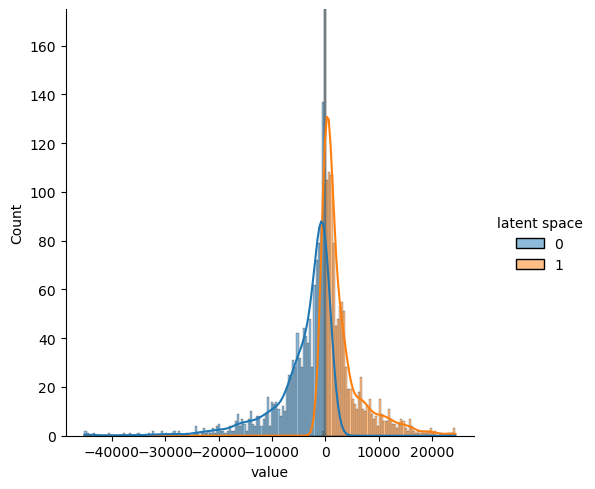

In [85]:
plt.figure(figsize = (8,15))
sns.displot(data=latent, x='value', hue = 'latent space', kde=True)
plt.ylim(0, 175)

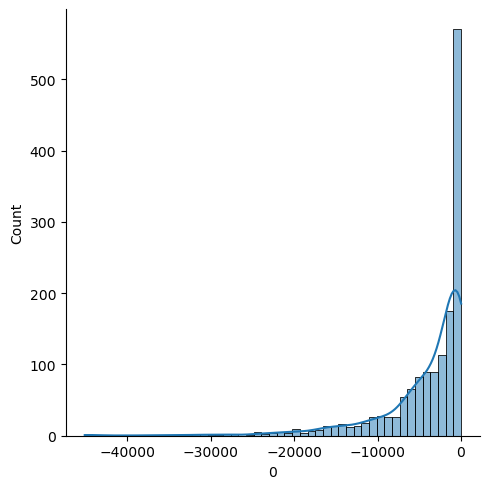

In [63]:
sns.displot(data=latent, x=0, kde=True)

<AxesSubplot: >

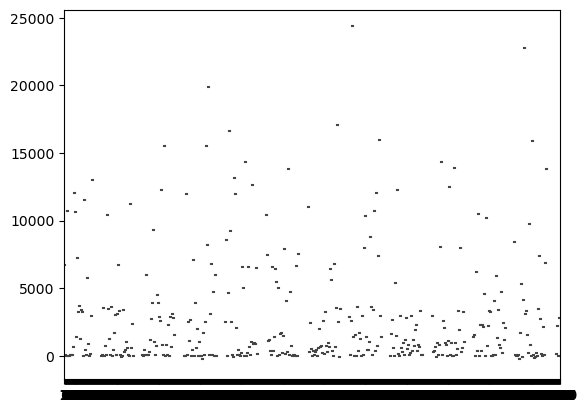

In [49]:
sns.violinplot(bla[:,1])

(1500, 10)

Accuracy is 97.51%
MSE for radius per shape for correctly identified instances as follows: sphere: 0.1235, hardsphere: 1.2953 and cylinder: 0.5816
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0006, hardsphere: 0.0007 and cylinder: 0.0009
MSE for cylinder length for correctly identified instances: 16.5584
MSE for cylinder length polydispersity for correctly identified instances: 0.0025
MSE for cylinder length for correctly identified instances: 0.0004


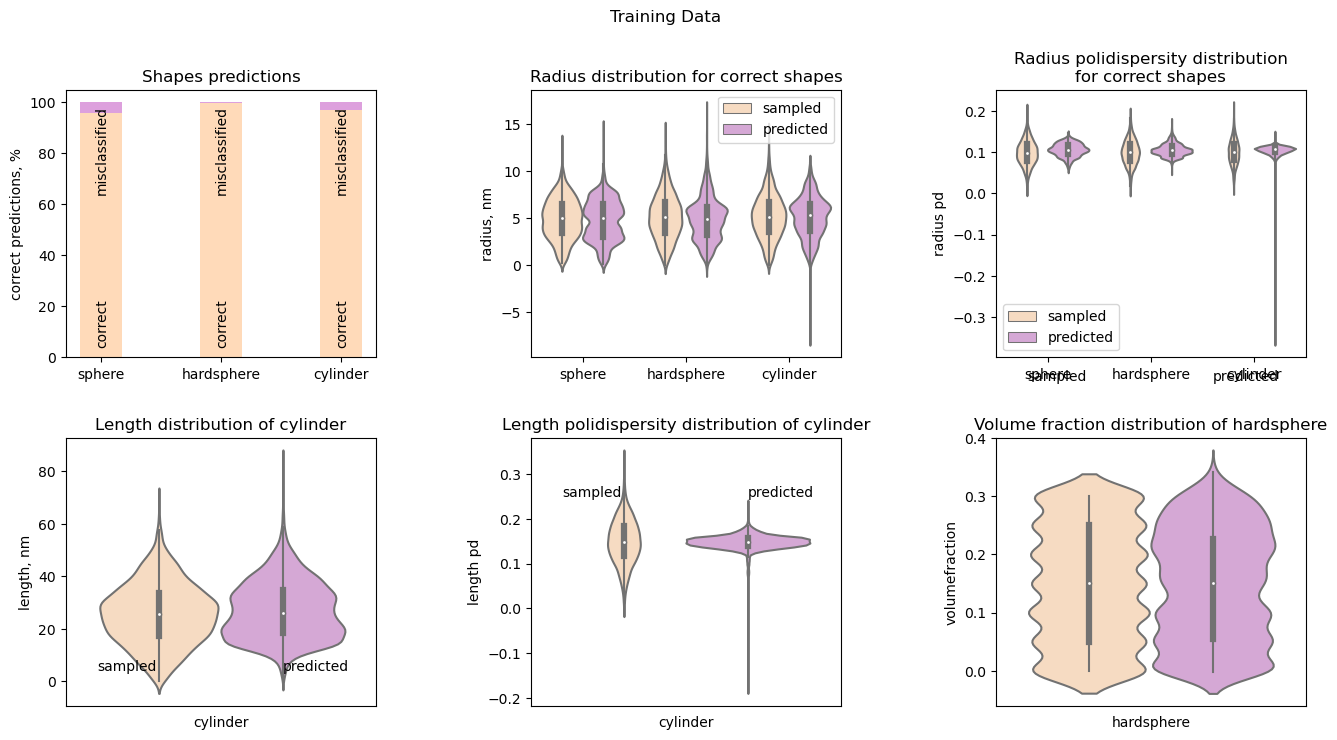

In [12]:
plot_outcomes_identified(df_train, 'Training')

In [13]:
df_train

,true_shape,pred_shape,radius,pred_radius,radius_pd,pred_radius_pd,length,pred_length,length_pd,pred_length_pd,volfraction,pred_volfraction
0,0,0,4.319663,4.047693,0.060623,0.087958,0.000000,1.235577,0.000000,0.005481,0.00,-0.001061
1,1,1,6.626724,6.222324,0.138689,0.129935,0.000000,1.063022,0.000000,-0.001293,0.15,0.156116
2,1,1,4.938429,4.920234,0.061872,0.087764,0.000000,0.112721,0.000000,0.003677,0.15,0.156700
3,1,1,3.169132,2.913420,0.076382,0.096982,0.000000,0.258076,0.000000,0.002072,0.20,0.201032
4,1,1,4.523155,4.834736,0.069551,0.107954,0.000000,0.491061,0.000000,0.000430,0.00,0.011047
...,...,...,...,...,...,...,...,...,...,...,...,...
10495,2,2,3.454283,3.742016,0.137844,0.109413,45.847954,46.290763,0.142283,0.157120,0.00,0.002000
10496,0,0,5.894809,5.894047,0.106553,0.103065,0.000000,0.171530,0.000000,0.003326,0.00,-0.001695
10497,1,1,6.187733,6.038145,0.080389,0.100399,0.000000,0.527433,0.000000,0.002074,0.05,0.048722
10498,2,2,4.883616,5.197280,0.083301,0.108952,25.845156,25.975584,0.186235,0.136790,0.00,-0.003369


Accuracy is 97.13%
MSE for radius per shape for correctly identified instances as follows: sphere: 0.1035, hardsphere: 1.0553 and cylinder: 0.4468
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0006, hardsphere: 0.0008 and cylinder: 0.0008
MSE for cylinder length for correctly identified instances: 16.8408
MSE for cylinder length polydispersity for correctly identified instances: 0.0025
MSE for cylinder length for correctly identified instances: 0.0006


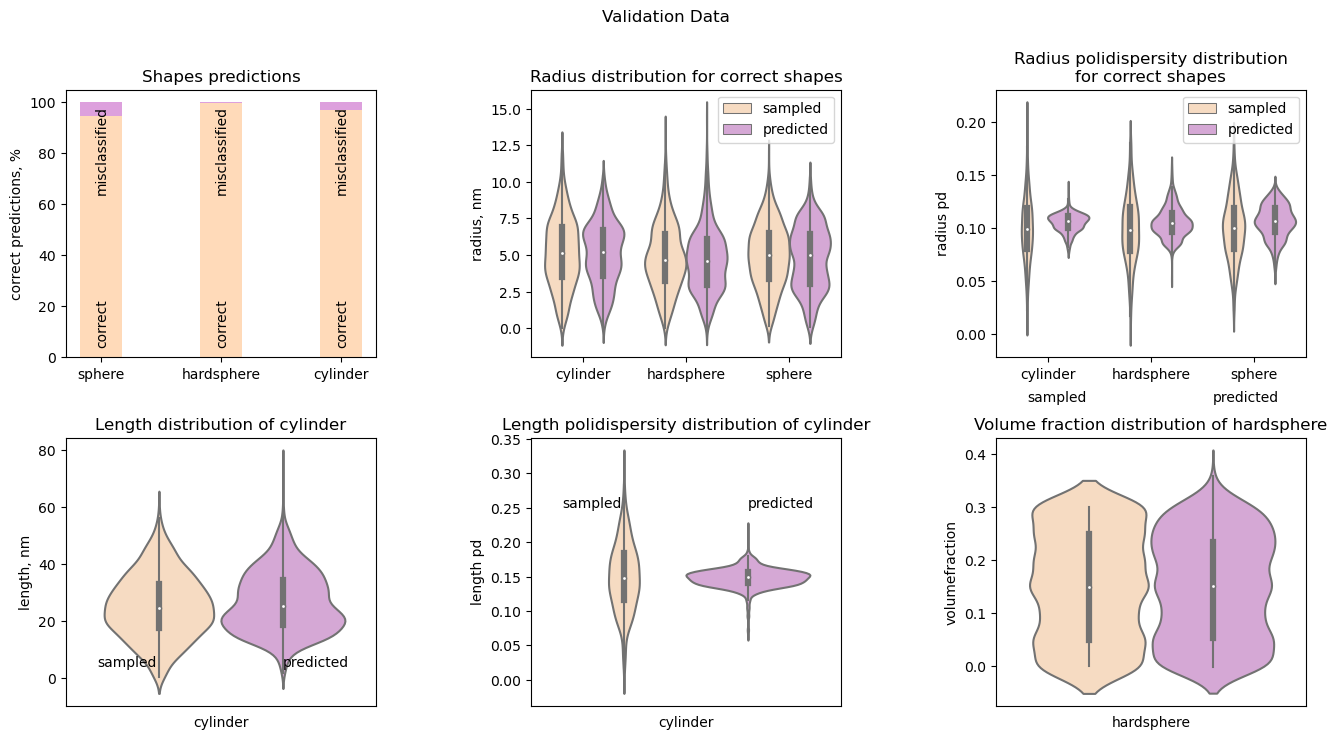

In [14]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 97.47%
MSE for radius per shape for correctly identified instances as follows: sphere: 0.1100, hardsphere: 1.3438 and cylinder: 0.4475
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0006, hardsphere: 0.0008 and cylinder: 0.0008
MSE for cylinder length for correctly identified instances: 15.8771
MSE for cylinder length polydispersity for correctly identified instances: 0.0026
MSE for cylinder length for correctly identified instances: 0.0006


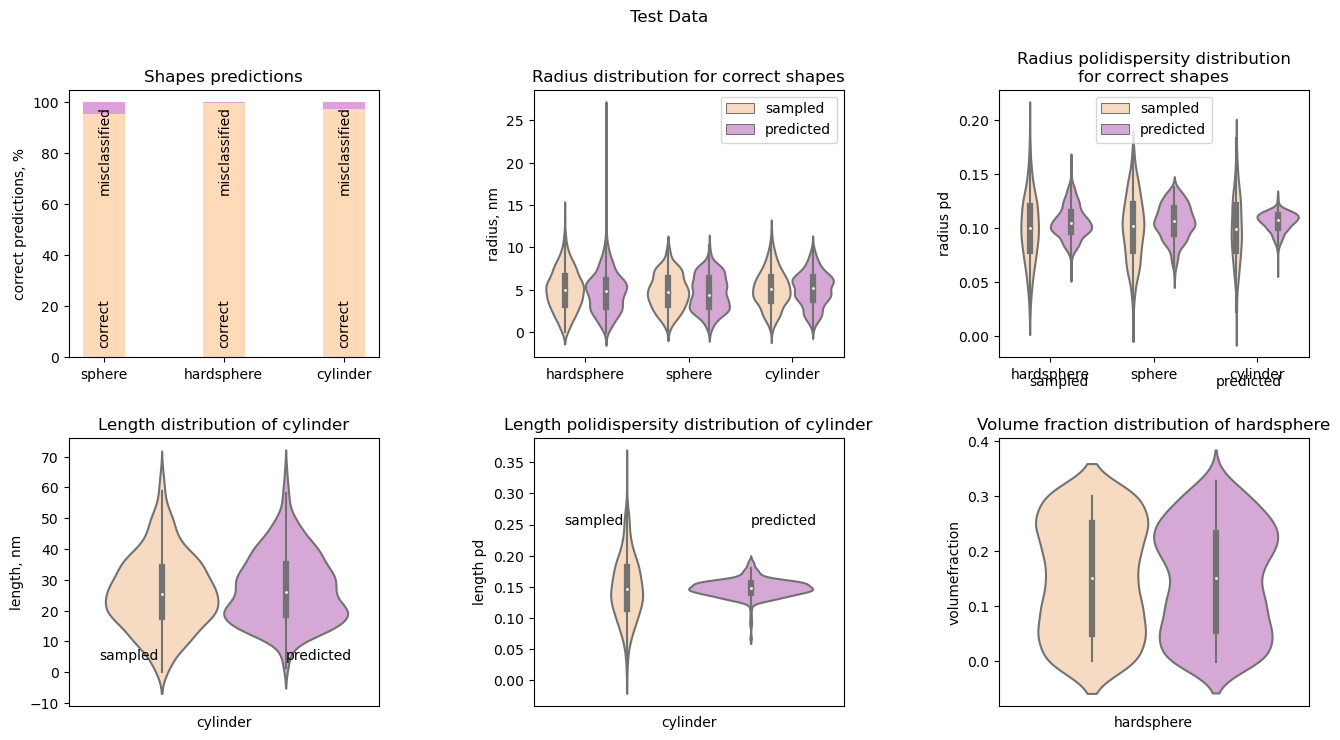

In [15]:
plot_outcomes_identified(df_test, 'Test')

In [16]:
import seaborn as sns
from sklearn.metrics import mean_squared_error
def MSE(sampled, predicted):
    if len(sampled) == 0:
        return np.inf
    else:
        return mean_squared_error(sampled, predicted)

def set_value(row, true_shape, colname_true, colname_pred):
    if row.true_shape == true_shape:
        return row[colname_true]
    else:
        return row[colname_pred]
def set_label(row, true_shape, label_true, label_false):
    if row.true_shape == true_shape:
        return label_true
    else:
        return label_false


In [17]:
df = df_test

In [18]:
print('MSE for radius per shape for correctly identified instances as follows: sphere: {sMSE:.4f}, hardsphere: {hsMSE:.4f} and cylinder: {cMSE:.4f}'.format\
    (sMSE = MSE(df[(df.true_shape == 0) & (df.pred_shape == 0)].radius, df[(df.true_shape == 0) & (df.pred_shape == 0)].pred_radius), 
        hsMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].radius, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_radius),
        cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].radius, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_radius)))
   

MSE for radius per shape for correctly identified instances as follows: sphere: 0.1100, hardsphere: 1.3438 and cylinder: 0.4475


In [19]:
 
#print('Total radius MSE is {err:.2f}'.format(err= mean_squared_error(df.radius, df.pred_radius)))
print('MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: {sMSE:.4f}, hardsphere: {hsMSE:.4f} and cylinder: {cMSE:.4f}'.format\
    (sMSE = MSE(df[(df.true_shape == 0) & (df.pred_shape == 0)].radius_pd, df[(df.true_shape == 0) & (df.pred_shape == 0)].pred_radius_pd), 
        hsMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].radius_pd, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_radius_pd),
        cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].radius_pd, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_radius_pd)))

print('MSE for cylinder length for correctly identified instances: {cMSE:.4f}'.format\
    (cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].length, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_length)))
print('MSE for cylinder length polydispersity for correctly identified instances: {cMSE:.4f}'.format\
    (cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].length_pd, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_length_pd)))
print('MSE for cylinder length for correctly identified instances: {hMSE:.4f}'.format\
    (hMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].volfraction, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_volfraction)))

MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0006, hardsphere: 0.0008 and cylinder: 0.0008
MSE for cylinder length for correctly identified instances: 15.8771
MSE for cylinder length polydispersity for correctly identified instances: 0.0026
MSE for cylinder length for correctly identified instances: 0.0006
